## Gradient Boosting for Classification
The intuition behind `gradient boosting` algorithm is to leverage the pattern
in residuals and strenghten a weak prediction model, until our residuals
become randomly (maybe random normal too) distributed. Once we reach a
stage that residuals do not have any pattern that can be modeled, we can stop
modeling residuals (as it might lead to overfitting).

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.datasets import make_moons
from sklearn.tree import DecisionTreeRegressor

sns.set()

## Create simulated dataset with non-trivial decision boundary

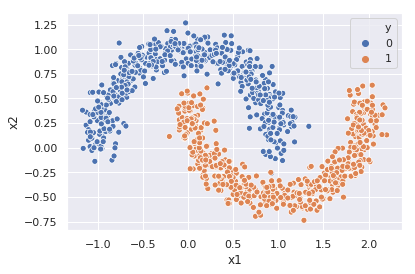

In [2]:
ds = make_moons(1000, noise=0.1, random_state=0)
moons_x = ds[0]
moons_y = ds[1]

data = pd.DataFrame({"x1": moons_x[:, 0], "x2": moons_x[:, 1], "y": moons_y})
sns.scatterplot(x=data["x1"], y=data["x2"], hue=data["y"])
plt.show()

## Utility functions

In [3]:
def sigmoid(data):
    """ sigmoid function to convert regressor output to probabilities """
    return 1.0 / (1 + np.exp(-data))

In [4]:
def make_meshgrid(x, y, h=0.02):
    """ generate grid to predict for decision boundary """
    x_min, x_max = x.min() - 0.5, x.max() + 0.5
    y_min, y_max = y.min() - 0.5, y.max() + 0.5
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    return xx, yy

## Gradient Boosting (DecisionTrees in a loop)

We will use binary cross entropy loss for boosting. For gradient boosting, we
use the negative gradient of loss function w.r.t output as the 'residual'
which subsequent trees will fit.

The negative gradient for cross entropy loss is `(y-pred)` where `y` is the
target class probability (1 or 0), and `pred` is the predicted class probability.

In [5]:
X_train = data[["x1", "x2"]].values
Y = data["y"].values
n_estimators = 200  # number of boosted trees to fit
rate = 1  # learning rate

# points to evaluate during prediction
xx, yy = make_meshgrid(X_train[:, 0], X_train[:, 1], h=0.05)

# initiate vector for combined predictions
# combined_preds = np.zeros(len(Y)) + Y.mean()
combined_preds = np.zeros(len(Y))
bnd_combined_preds = np.zeros(len(xx.ravel()))

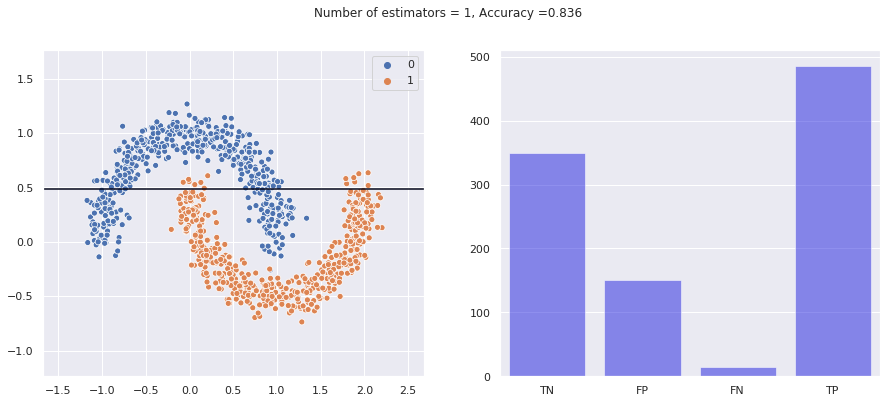

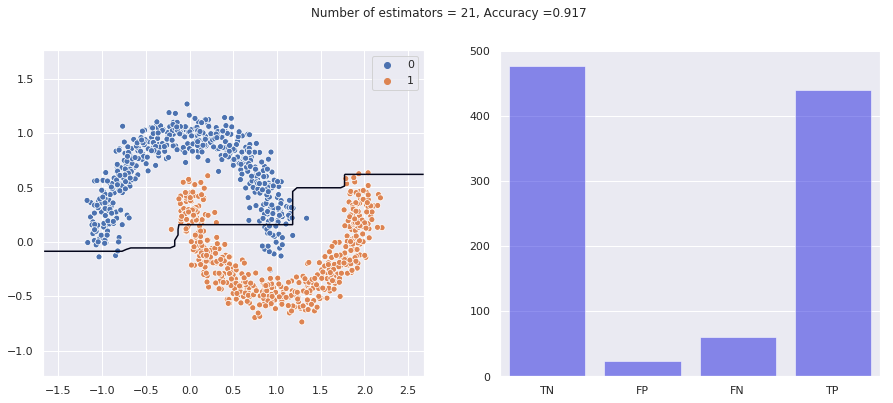

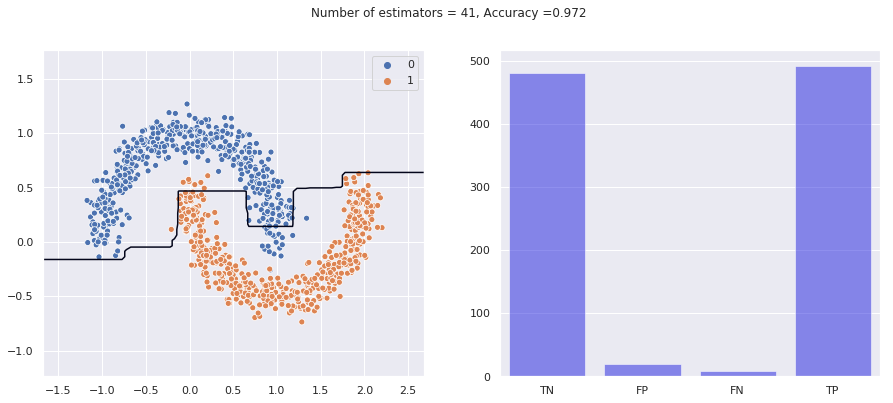

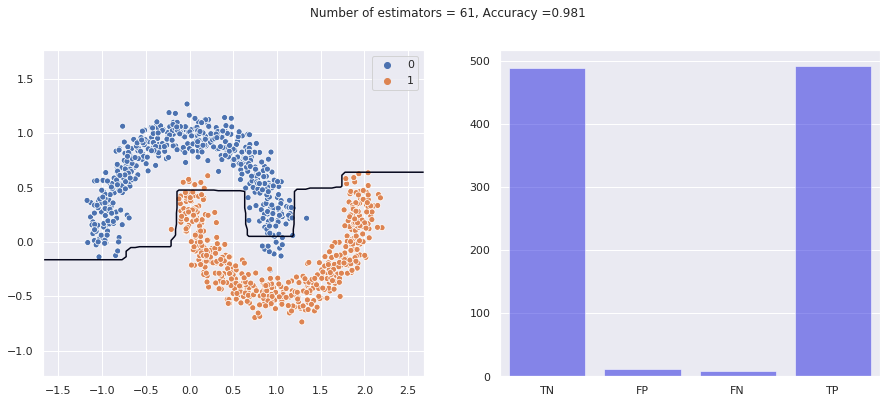

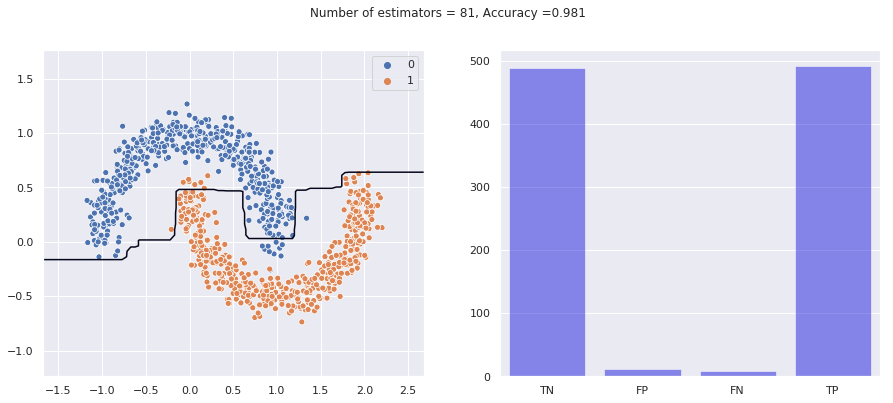

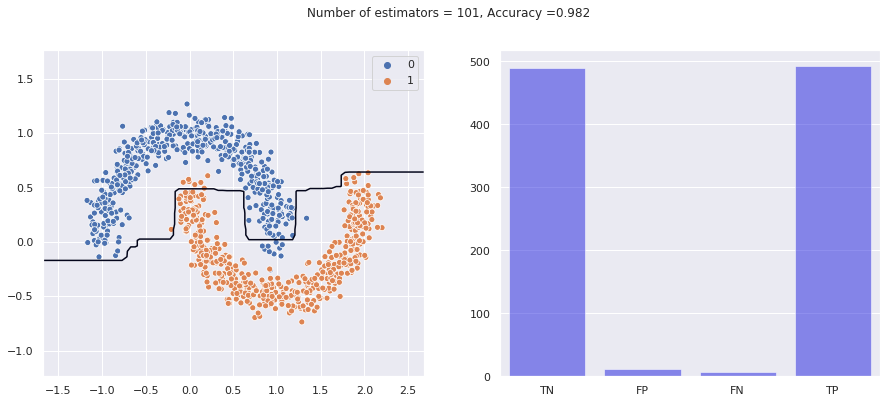

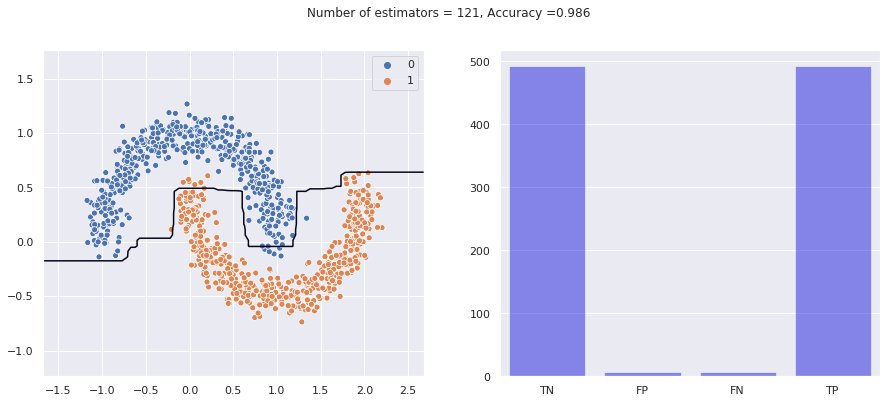

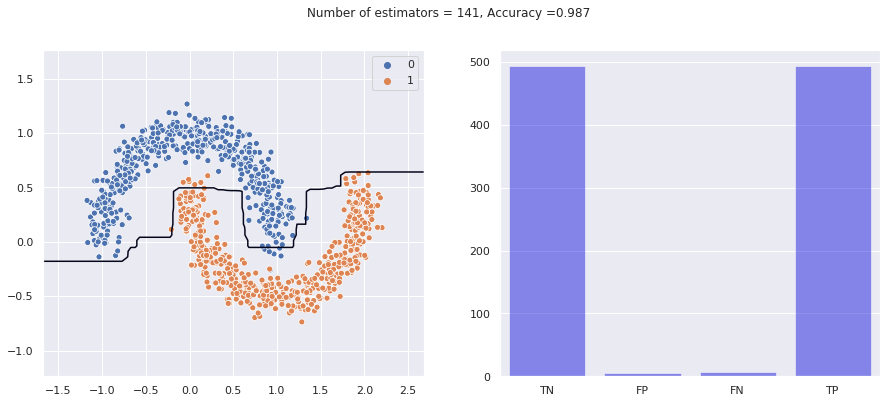

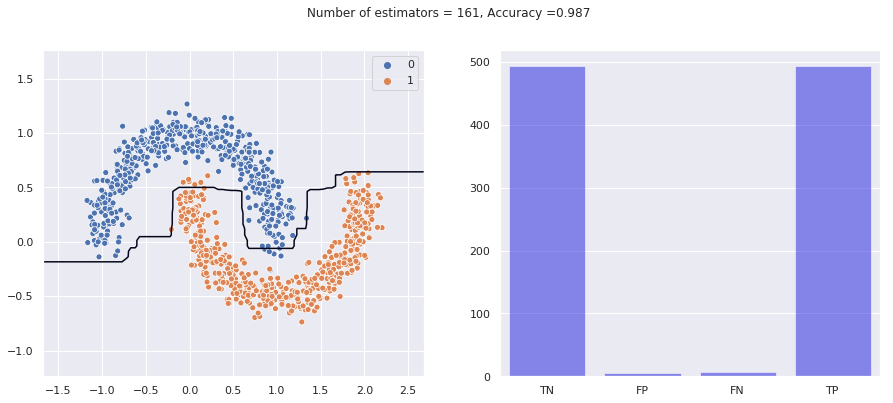

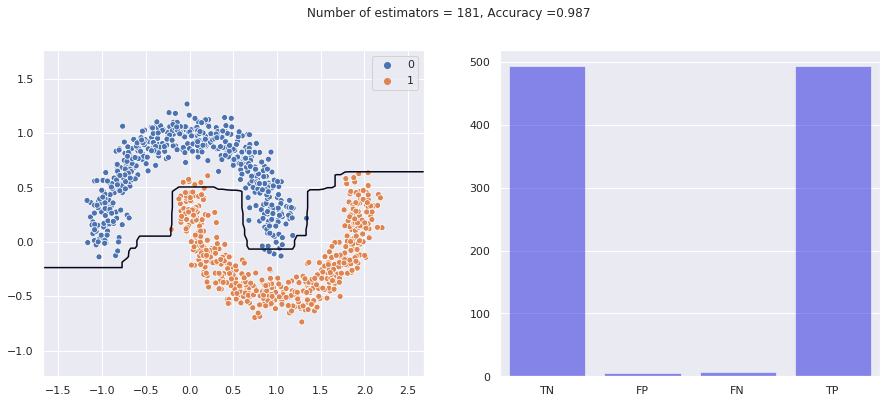

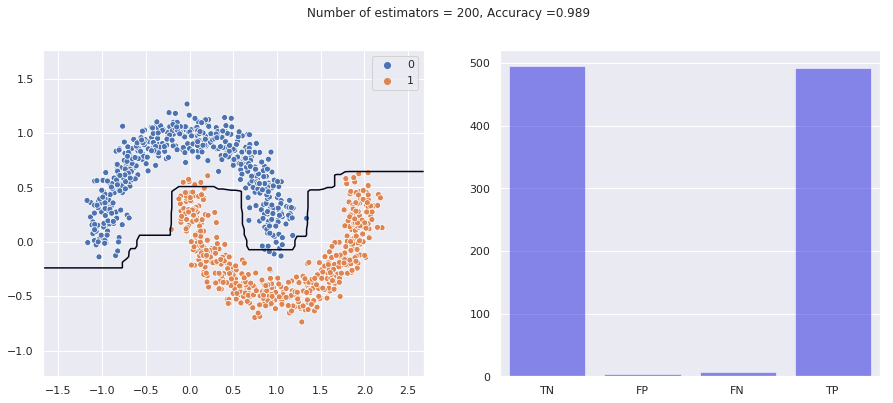

In [6]:
# iteratively boost trees using residuals from previous tree
for i in range(n_estimators):

    # initialize a simple decision tree
    clf = DecisionTreeRegressor(max_depth=1, random_state=1234)

    # calculate negative gradient for binary cross entropy loss to fit using classifier
    Y_train = Y - sigmoid(combined_preds)

    # train classifier
    clf.fit(X_train, Y_train)

    # predict target
    preds = clf.predict(X_train)
    preds

    # combine predictions
    combined_preds = combined_preds + rate * preds

    # obtain predicted probability for class 1, and binary class label
    pred_probs = sigmoid(combined_preds)
    pred_class = (pred_probs > 0.5).astype(int)

    # calculate accuracy
    acc = accuracy_score(Y, pred_class)
    confusion = confusion_matrix(Y, pred_class).ravel()

    # generate predictions over a (fine) grid for the decision boundary
    bnd_preds = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    bnd_combined_preds = bnd_combined_preds + bnd_preds
    z = sigmoid(bnd_combined_preds).reshape(xx.shape)

    # plot a scatter plot with a decision boundary + a barplot of the confusion
    # matrix
    if i % 20 == 0 or i == 0 or i == n_estimators - 1:
        f, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
        tl = "Number of estimators = " + str(i + 1)
        tl += ", Accuracy =" + str(np.round(acc, 3))

        f.suptitle(tl)
        ax1.contour(xx, yy, z, levels=[0.5])
        sns.scatterplot(x=X_train[:, 0], y=X_train[:, 1], hue=Y, ax=ax1)
        sns.barplot(
            x=["TN", "FP", "FN", "TP"], y=confusion, color="blue", alpha=0.5, ax=ax2
        )
        f.show()